# Neural Style Transfer

Author: Athan Zhang (athanzxyt)

Neural Style Transfer (NST) is a technique in deep learning that combines the content of one image with the style of another. It uses a pre-trained convolutional neural network to extract and compare feature representations from the content and style images. By optimizing the content image to match the style features, a new image is generated that exhibits the content of the original image but with the artistic style of the style image.

Following the original paper (https://arxiv.org/abs/1508.06576), we will use the VGG-Network network. We will use the 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers).

https://www.youtube.com/watch?v=imX4kSKDY7s&ab_channel=AladdinPersson 

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt

## Load Images

In [13]:
def load_img(img_name):
    img = loader(Image.open(img_name)).unsqueeze(0)
    return img.to(device, torch.float)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 256

loader = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

unloader = transforms.Compose([
#     transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
#     transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    transforms.ToPILImage()
])

C_img = load_img("birthday.jpeg")
S_img = load_img("vangogh.jpeg")
G_img = C_img.clone().requires_grad_(True)

assert C_img.size() == S_img.size()

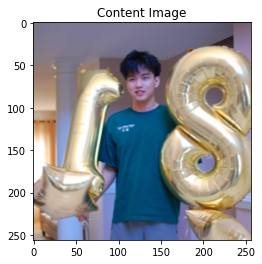

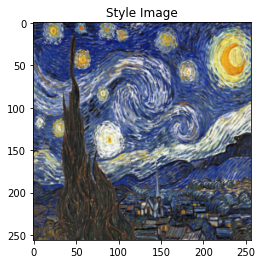

In [15]:
def imgshow(tensor, title=None):
    img = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    img = img.squeeze(0)      # remove the fake batch dimension
    img = unloader(img)
    plt.imshow(img)
    if title is not None:
        plt.title(title)

plt.figure()
imgshow(C_img, title='Content Image')        
        
plt.figure()
imgshow(S_img, title='Style Image')

## Build and Train model

In [16]:
class VGG(nn.Module):
    
    def __init__(self):
        super(VGG, self).__init__()
        
        self.chosen_features = ['0', '5', '10', '19', '28']
        self.model = models.vgg19(pretrained = True).features[:29]
        
    def forward(self, x):
        features = []
        
        for layer_idx, layer in enumerate(self.model): 
            x = layer(x)
            if str(layer_idx) in self.chosen_features: features.append(x)
                
        return features

In [21]:
# Hyperparameters
epochs = 1000
lr = 0.001
alpha = 1
beta = 0.05
optimizer = optim.Adam([G_img], lr=lr)

# Train
model = VGG().to(device).eval()
for epoch in range(epochs):
    G_features = model(G_img)
    C_features = model(C_img)
    S_features = model(S_img)
    
    S_loss = C_loss = 0
    
    for G_feat, C_feat, S_feat in zip(G_features, C_features, S_features):
        batch_size, channel, height, width = G_feat.shape
        C_loss += torch.mean((G_feat - C_feat) ** 2)
        
        # Compute Gram Matrix
        G = G_feat.view(channel, height*width).mm(
            G_feat.view(channel, height*width).t()
        )
        
        A = S_feat.view(channel, height*width).mm(
            S_feat.view(channel, height*width).t()
        )
        
        S_loss += torch.mean((G - A) ** 2)
        
    total_loss = alpha*C_loss + beta*S_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: {total_loss}")
        save_image(G_img, f"generated{epoch}.jpeg")

Epoch 0: 1464469.375
Epoch 100: 79490.2734375
Epoch 200: 34325.73828125
Epoch 300: 23383.283203125
Epoch 400: 18155.72265625
Epoch 500: 15054.4443359375
Epoch 600: 12927.5751953125
Epoch 700: 11393.39453125
Epoch 800: 10241.2998046875
Epoch 900: 9334.83203125


## Show Generated Image

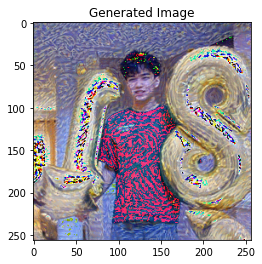

In [22]:
plt.figure()
imgshow(G_img, title='Generated Image')